## Easy Experiment .ipynb File

# train

## import

In [1]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [2]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [4]:
### cofiguration
seed = 42
check_point_dir_name = 'standard'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 500
train_ratio = 0.8
epochs = 50
print_interval = 412
lr = 1e-4
model_name = 'efficientnet_b4'
num_labels = 18
loss_function_name = 'FocalLoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
scheduler_name = 'ReduceLROnPlateau'
comment = 'change transforms, change train_ratio, plus epochs, add Scheduler ReduceLROnPlateau'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [5]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['class'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

In [6]:
os.makedirs(save_dir,exist_ok=True)

In [7]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : 1e-4,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [8]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [9]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [10]:
train_transforms = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.2),
        A.GridDistortion(p=0.2),
        A.Rotate(limit = 15, p=0.5),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

In [11]:
# train_transforms = A.Compose([A.Resize(height=224, width=224),
#                               A.HorizontalFlip(p=0.5),
#                               A.RandomBrightnessContrast(p=0.5),
#                               A.GaussianBlur(p=0.5),
#                               A.GridDistortion(p=0.5),
#                               A.Rotate(limit=30, p=0.5),
#                               A.Normalize(mean=(0.56019358,0.52410121,0.501457),
#                               std=(0.23318603,0.24300033,0.24567522)),
#                               ToTensorV2()])

# valid_transforms = A.Compose([A.Resize(height=224, width=224),
#                               A.Normalize(mean=(0.56019358,0.52410121,0.501457),
#                               std=(0.23318603,0.24300033,0.24567522)),
#                               ToTensorV2()])

## make dataset and dataloader

In [12]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'class', train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_labels, 'class', valid_transforms)

In [13]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

## visualization transform

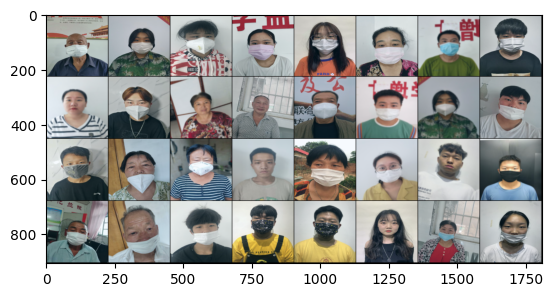

In [14]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [15]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)
model = torch.nn.DataParallel(model)

## Loss function

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [17]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

## Optimizer

In [18]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

## Scheduler  

In [19]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3) ## 정리

assert scheduler != None , 'sheduler is None'

## Train

In [20]:

best_val_acc = 0
best_val_f1 = 0
best_val_loss = np.Inf

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.to(device)

        b_logits = model(b_imgs)
        b_loss = criterion(b_logits, b_labels)
        b_preds = torch.argmax(b_logits, dim=-1)

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss += b_loss.item()
        epoch_preds += b_preds.detach().cpu().numpy().tolist()
        epoch_labels += b_labels.detach().cpu().numpy().tolist()

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # /batch
            correct_list = [i==j for i,j in zip(epoch_preds, epoch_labels)]
            current_acc = sum(correct_list) / len(correct_list)
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss {current_loss:2.4f} || training accuracy {current_acc:4.2%} || lr {lr}"
                )

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()

        val_loss = []
        val_acc = []

        val_preds = [] # every data's preds
        val_labels = [] # every data's label

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # print('labels shape:', labels.size())

            logits = model(imgs)
            b_loss = criterion(logits, labels).item()
            
            preds = torch.argmax(logits, dim=-1)
            # print('preds shape:', preds.size())

            correct_num = (labels == preds).sum().item()

            val_loss.append(b_loss)
            val_acc.append(correct_num)

            val_preds += preds.detach().cpu().numpy().tolist()
            val_labels += labels.detach().cpu().numpy().tolist()

        epoch_val_loss =  np.sum(val_loss)/len(val_loader)
        epoch_val_acc = np.sum(val_acc)/len(val_dset)
        epoch_val_f1 = f1_score(val_labels, val_preds, average='macro')
        
        best_val_loss = min(best_val_loss, epoch_val_loss)

        if epoch_val_f1 > best_val_f1:
                print(f"New best model for val f1 : {epoch_val_f1:2.4f}! saving the best model..")
                best_val_f1 = epoch_val_f1
                torch.save(model.module.state_dict(), f"{save_dir}/best.pth")
        if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
        torch.save(model.module.state_dict(), f'{save_dir}/last.pth')
        print(
                f"[Val] f1 : {epoch_val_f1:2.4f}, loss: {epoch_val_loss:2.4f}, acc: {epoch_val_acc:4.2%} || "
                f"best f1 : {best_val_f1:2.4f}, best loss: {best_val_loss:2.4f}, best acc: {best_val_acc:4.2%}"
            )
        scheduler.step(epoch_val_loss)


Epoch[1/50](412/414) || training loss 0.7990 || training accuracy 66.47% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.6386! saving the best model..
[Val] f1 : 0.6386, loss: 0.2753, acc: 80.37% || best f1 : 0.6386, best loss: 0.2753, best acc: 80.37%
Epoch[2/50](412/414) || training loss 0.2171 || training accuracy 84.90% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.7396! saving the best model..
[Val] f1 : 0.7396, loss: 0.1697, acc: 85.22% || best f1 : 0.7396, best loss: 0.1697, best acc: 85.22%
Epoch[3/50](412/414) || training loss 0.1212 || training accuracy 90.31% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.7815! saving the best model..
[Val] f1 : 0.7815, loss: 0.1155, acc: 87.95% || best f1 : 0.7815, best loss: 0.1155, best acc: 87.95%
Epoch[4/50](412/414) || training loss 0.0755 || training accuracy 92.98% || lr 0.0001
Calculating validation results...
New best model for val f1 : 0.8196

```
제출 f1 : 0.6345
[Val] f1 : 0.9198, loss: 0.0420, acc: 94.55% || best f1 : 0.9280, best loss: 0.0355, best acc: 94.92%
{
    "seed": 42,
    "train_b_size": 32,
    "epochs": 30,
    "lr": 0.0001,
    "model_name": "efficientnet_b4",
    "num_labels": 18,
    "loss_function_name": "FocalLoss",
    "optimizer_name": "AdamW",
    "comment": "For Error label amend"
}
```

# inference

## inference config

In [ ]:
model_name = 'resnet34'
check_point_dir_name = 'resnet34'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 1000
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [ ]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_transforms = A.Compose([A.Resize(height=224, width=224),
                                 A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                                 std=(0.23318603,0.24300033,0.24567522)),
                                 ToTensorV2()])

In [ ]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [ ]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [ ]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")